In [1]:
%matplotlib notebook

import xemc3
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr
import numpy as np

#import mapping_geometry_data_evaluation as mgde
cmap = mpl.cm.magma

In [8]:
bolotype = "QSB"
experiment  = "N03.00_P05.00_D05_R02.00-C" # "N03.00_P05.00_D05_C04.50-TEST"

ds = xr.open_dataset(f"../atomdatpy/NetCDFs-new/{experiment}.nc")
ds_map = xr.open_dataset(f"./{bolotype}-dataset.nc")

# grid dimensions
dim_sizes_C = ds_map.S.shape[1:]
dim_sizes_T = ds.Ez.shape[1:]
dim_names_C = ds_map.S.dims[1:]
dim_names_T = ds.Ez.dims[1:]

# radiated power density in [T] (Ionization, r, theta, phi)
ez_T = ds.Ez

# Sensitivity / geometry matrix in [C] (foil, p, z, r)
gm_C = ds_map.S

# [C] -> [T] mapping (*[C], sample, [T]coord)
# map_C_T[*coord_in_C][sample] == [r, theta, phi]
map_C_T = ds_map.Map # keep as floats so nans stay
map_C_T_int = ds_map.Map.astype(int)

In [9]:
ez_C = xr.open_dataset(f"./tempdata/emissivity_C_{bolotype}_{experiment}.nc")
gm_T = xr.open_dataset(f"./tempdata/geometry_matrix_T_{bolotype}_{experiment}.nc")

ez_C = ez_C.__xarray_dataarray_variable__
gm_T = gm_T.__xarray_dataarray_variable__

None

In [10]:
def crossec_pcolorgrid_gabriele(ds, phi):
    # (A+1)*(B+1) = AB + A + B +1
    outR = np.empty((len(ds["z"])+1, len(ds["r"])+1))
    outZ = outR.copy()
    
    outZ[:-1,:-1] = ds["z_vert"][phi, :, :,0,0,0]  # AB
    outZ[:-1, -1] = ds["z_vert"][phi, :,-1,0,0,1]  # A
    outZ[ -1,:-1] = ds["z_vert"][phi,-1, :,0,1,0]  # B
    outZ[ -1, -1] = ds["z_vert"][phi,-1,-1,0,1,1]  # 1
    
    outR[:-1,:-1] = np.sqrt( ds["x_vert"][phi, :, :,0,0,0]**2 + ds["y_vert"][phi, :, :,0,0,0]**2 ) # AB
    outR[:-1, -1] = np.sqrt( ds["x_vert"][phi, :,-1,0,0,1]**2 + ds["y_vert"][phi, :,-1,0,0,1]**2 ) # A
    outR[ -1,:-1] = np.sqrt( ds["x_vert"][phi,-1, :,0,1,0]**2 + ds["y_vert"][phi,-1, :,0,1,0]**2 ) # B
    outR[ -1, -1] = np.sqrt( ds["x_vert"][phi,-1,-1,0,1,1]**2 + ds["y_vert"][phi,-1,-1,0,1,1]**2 ) # 1
    
    return outR.T, outZ.T

def crossec_pcolorgrid_philip(ds, phi):
    # (A+1)*(B+1) = AB + A + B +1
    outR = np.empty((len(ds["r"])+1, len(ds["theta"])+1))
    outZ = outR.copy()
    
    outR[:-1,:-1] = ds["R_bounds"][ :, :,phi,0,0,0]  # AB
    outR[:-1, -1] = ds["R_bounds"][ :,-1,phi,0,1,0]  # A
    outR[ -1,:-1] = ds["R_bounds"][-1, :,phi,1,0,0]  # B
    outR[ -1, -1] = ds["R_bounds"][-1,-1,phi,1,1,0]  # 1
    
    outZ[:-1,:-1] = ds["z_bounds"][ :, :,phi,0,0,0]  # AB
    outZ[:-1, -1] = ds["z_bounds"][ :,-1,phi,0,1,0]  # A
    outZ[ -1,:-1] = ds["z_bounds"][-1, :,phi,1,0,0]  # B
    outZ[ -1, -1] = ds["z_bounds"][-1,-1,phi,1,1,0]  # 1
    
    return outR, outZ

def approx_volume(ds_all): # APPROXIMATION
    # ds_all.R_bounds.diff(dim="delta_r").diff(dim="delta_theta").diff(dim="delta_phi").squeeze(dim=("delta_r", "delta_theta", "delta_phi"))
    drr = ds_all.R_bounds.diff(dim="delta_r").squeeze(dim="delta_r").mean(dim=("delta_theta", "delta_phi"))
    dzr = ds_all.z_bounds.diff(dim="delta_r").squeeze(dim="delta_r").mean(dim=("delta_theta", "delta_phi"))

    drtht = ds_all.R_bounds.diff(dim="delta_theta").squeeze(dim="delta_theta").mean(dim=("delta_r", "delta_phi"))
    dztht = ds_all.z_bounds.diff(dim="delta_theta").squeeze(dim="delta_theta").mean(dim=("delta_r", "delta_phi"))

    # length = r * dphi
    dlphi = ds_all.R_bounds.mean(dim=("delta_r", "delta_theta", "delta_phi")) * \
            ds_all.phi_bounds.diff(dim="delta_phi").squeeze(dim="delta_phi")  # .data[None, None, :]  dont need to do cause of xarray dims

    # vol = det ((drr, drtht, 0), (dzr, dztht, 0), (0, 0, dlphi))
    #     = det ((drr, drtht), (dzr, dztht)) * dlphi
    #     = (drr * dztht - dzr * drtht) * dlphi
    vols = (drr * dztht - dzr * drtht) * dlphi
    return vols

import ipywidgets as widgets
def combination_plot_gm(ds_gabriele, ds_emc3, gm_T, phi, foil_index=0, 
                        scale_by_volume=False, sf=lambda x: x, interactive=True, **kwargs):
    # embed matrix into coords
    ds_emc3["foil_geom_matrix"] = gm_T
    ds_emc3["volumes"] = approx_volume(ds_emc3) # (["r", "theta", "phi"], approx_volume(ds_emc3))
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,7), **kwargs)
    axs[0].set_aspect("equal")
    axs[1].set_aspect("equal")
    fig.tight_layout()
    
    def _combination_plot(phi):
        # plot 1
        axs[0].clear()
        first_module_phi = np.minimum( phi%(2*np.pi/5), 2*np.pi/5 - phi%(2*np.pi/5) )
        phi_index = np.searchsorted(ds_emc3.phi_bounds[:,1], first_module_phi)
                   # np.clip(np.searchsorted(ds_emc3.phi_bounds[:,1], phi),
                   #          0, len(ds_emc3.phi_bounds[:,1])-1)
        try:
            R, Z = crossec_pcolorgrid_philip(ds_emc3, phi_index)
            C = ds_emc3["foil_geom_matrix"].isel(phi=phi_index, foil=foil_index).copy()
            if scale_by_volume:
                C /= ds_emc3["volumes"].isel(phi=phi_index)
            cb = axs[0].pcolormesh(R, Z, sf(C), cmap=cmap)
            # fig.colorbar(cb, ax=axs[0])
        except:
            ...

        # plot 2
        axs[1].clear()
        phi_index = np.argmin(( (ds_gabriele.phi * (np.pi/180) - phi)**2 ).data)
        R,Z = crossec_pcolorgrid_gabriele(ds_gabriele, phi_index)
        C = ds_gabriele["S"].isel(p=phi_index, foil=foil_index).T.copy()
        if scale_by_volume:
            C /= ds_gabriele["V"].isel(p=phi_index).T
        axs[1].pcolormesh(R, Z, sf(C), cmap=cmap)
    

    delta_phi = np.mean(np.diff(ds_gabriele.phi.data)) * (np.pi/180)
    all_phi = ds_gabriele.phi.data * (np.pi/180)
    if interactive:
        interactive_phi = widgets.FloatSlider(min=min(all_phi) - delta_phi/2, 
                                              max=max(all_phi) + delta_phi/2, 
                                              value=np.mean(all_phi), step=delta_phi/2)
        widgets.interact(_combination_plot, phi=interactive_phi)
    else:
        _combination_plot(phi)
        return fig, axs
    
def combination_plot_ez(ds_gabriele, ds_emc3, ez_C, phi, Ionization_index=0,
                        scale_by_volume=False, sf=lambda x: x, interactive=True, **kwargs):
    # embed matrix into coords
    ds_emc3["volumes"] = approx_volume(ds_emc3) # (["r", "theta", "phi"], approx_volume(ds_emc3))
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,7), **kwargs)
    axs[0].set_aspect("equal")
    axs[1].set_aspect("equal")
    fig.tight_layout()
    
    def _combination_plot(phi):
        # plot 1
        axs[0].clear()
        first_module_phi = np.minimum( phi%(2*np.pi/5), 2*np.pi/5 - phi%(2*np.pi/5) )
        phi_index = np.searchsorted(ds_emc3.phi_bounds[:,1], first_module_phi)
                   # np.clip(np.searchsorted(ds_emc3.phi_bounds[:,1], phi),
                   #          0, len(ds_emc3.phi_bounds[:,1])-1)
        try:
            R, Z = crossec_pcolorgrid_philip(ds_emc3, phi_index)
            C = ds_emc3["Ez"].isel(phi=phi_index, Ionization=Ionization_index).copy()
            if scale_by_volume:
                C /= ds_emc3["volumes"].isel(phi=phi_index)
            cb = axs[0].pcolormesh(R, Z, sf(C), cmap=cmap)
            # fig.colorbar(cb, ax=axs[0])
        except:
            ...

        # plot 2
        axs[1].clear()
        phi_index = np.argmin(( (ds_gabriele.phi * (np.pi/180) - phi)**2 ).data)
        R,Z = crossec_pcolorgrid_gabriele(ds_gabriele, phi_index)
        C = ez_C.isel(p=phi_index, Ionization=Ionization_index).T.copy()
        if scale_by_volume:
            C /= ds_gabriele["V"].isel(p=phi_index).T
        axs[1].pcolormesh(R, Z, sf(C), cmap=cmap)
    

    delta_phi = np.mean(np.diff(ds_gabriele.phi.data)) * (np.pi/180)
    all_phi = ds_gabriele.phi.data * (np.pi/180)
    if interactive:
        interactive_phi = widgets.FloatSlider(min=min(all_phi) - delta_phi/2, 
                                              max=max(all_phi) + delta_phi/2, 
                                              value=np.mean(all_phi), step=delta_phi/2)
        widgets.interact(_combination_plot, phi=interactive_phi)
    else:
        _combination_plot(phi)
        return fig, axs

<IPython.core.display.Javascript object>


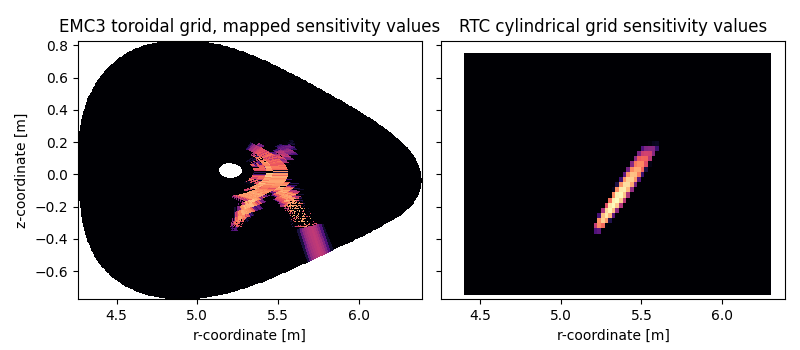

In [11]:
fig, axs = combination_plot_gm(ds_map, ds, gm_T, phi=1.87, foil_index=40,
                 sf = lambda x: np.log(x+1e-10), scale_by_volume=True, interactive=False, sharey=True, sharex=True)
axs[0].set_ylabel("z-coordinate [m]")
axs[1].set_xlabel("r-coordinate [m]")
axs[0].set_xlabel("r-coordinate [m]")
axs[0].set_title("EMC3 toroidal grid, mapped sensitivity values")
axs[1].set_title("RTC cylindrical grid sensitivity values")
fig.set_size_inches(8, 3.5, forward=True)
fig.tight_layout()

fig.savefig("./../images/preas-grid-mapping-CtoT.pdf")
fig.savefig("./../images/preas-grid-mapping-CtoT.png", dpi=200)

<IPython.core.display.Javascript object>


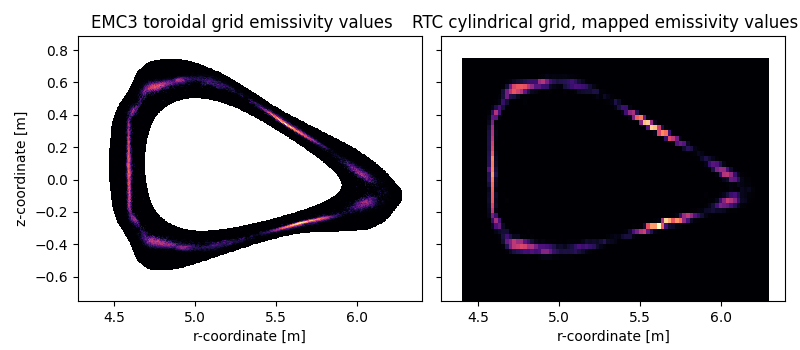

In [12]:
fig, axs = combination_plot_ez(ds_map, ds, ez_C, phi=1.85, Ionization_index=3,
                         sf = lambda x: np.log(x+1e+5), scale_by_volume=False, interactive=False, sharey=True, sharex=True)
axs[0].set_ylabel("z-coordinate [m]")
axs[1].set_xlabel("r-coordinate [m]")
axs[0].set_xlabel("r-coordinate [m]")
axs[0].set_title("EMC3 toroidal grid emissivity values   ")
axs[1].set_title("RTC cylindrical grid, mapped emissivity values   ")
fig.set_size_inches(8, 3.5, forward=True)
fig.tight_layout()

fig.savefig("./../images/preas-grid-mapping-TtoC.pdf")
fig.savefig("./../images/preas-grid-mapping-TtoC.png", dpi=200)